In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from networkx.generators.community import stochastic_block_model
from networkx.linalg.graphmatrix import adjacency_matrix
from numpy.linalg import norm
from scipy.linalg import eigh
from matplotlib import cm 
# set random seeds
# random.seed(11)
# np.random.seed(11)

In [2]:
class SFSC:

    def __init__(self, size_of_clusters, probs_of_sbm, max_freq, num_of_clusters):

        self.graph = np.asarray(adjacency_matrix(stochastic_block_model(size_of_clusters, probs_of_sbm)).todense())
        self.true_angles_by_cluster = dict()
        self.size_of_clusters = size_of_clusters
        self.N = size_of_clusters.sum()
        self.max_freq = max_freq
        self.num_of_clusters = num_of_clusters
        self.alpha_struc = None
        self.A_k = None
        self.Phi = None
        self.d_alpha = 2 * np.pi / self.max_freq
        self.Pi = np.eye(self.N)
        self.Rf = None
        self.cluster_id = None
        self.estimated_angles = None

    def generate_angles(self):

        self.alpha_struc = np.random.randint(self.max_freq, size=(self.N, self.N))
        self.alpha_struc[np.tril_indices(self.N)] = 0
        self.alpha_struc = self.alpha_struc + np.mod(-self.alpha_struc.T, self.max_freq)
        start_idx, end_idx = 0, 0
        for idx, b_size in enumerate(self.size_of_clusters):
            end_idx += b_size
            alphas = np.random.randint(self.max_freq, size=b_size)
            self.true_angles_by_cluster.setdefault(idx, alphas)
            self.alpha_struc[start_idx:end_idx, start_idx:end_idx] = np.mod(
                alphas.reshape(-1, 1) - alphas,
                self.max_freq
            )
            start_idx += b_size

        return None

    def construct_A_k(self):

        self.A_k = self.graph * np.exp(self.alpha_struc * 1j * self.d_alpha)
        _, eigen_vec = eigh(
            self.A_k,
            subset_by_index=[self.N - self.num_of_clusters, self.N - 1]
        )
        self.Phi = eigen_vec.T

        return None
    
    def cpqr(self):

        R = self.Phi.copy()
        for m in range(self.num_of_clusters):
            norm_sum = norm(R[m:, m:], axis=0)
            piv = np.argmax(norm_sum) + m
            R[:, [piv, m]] = R[:, [m, piv]]
            self.Pi[:, [piv, m]] = self.Pi[:, [m, piv]]
            _, tRm = SFSC.qr_method_one_step(R[m:, m:])
            R[m:, m:] = tRm

        self.Rf = R @ self.Pi.T
        self.cluster_id = np.argmax(np.abs(self.Rf), axis=0)
#         Phi_tmp = np.conjugate(self.Phi)
        self.estimated_angles = np.angle(self.Rf[self.cluster_id, np.array(range(self.N))])

        return None
    
    @staticmethod
    def qr_method_one_step(X):

        m, _ = X.shape
        r = X[:, 0]
        alpha = -np.exp(1j * np.angle(r[0])) * norm(r)
        e1 = np.zeros(m)
        e1[0] = 1
        u = r - alpha * e1
        v = u / norm(u)
        Q = np.eye(m) - 2 * v.reshape(-1, 1) @ np.conjugate(v).reshape(1, -1)
        R = Q @ X
        R[0, :] = np.exp(-1j * np.angle(R[0, 0])) * R[0, :]

        return Q, R

In [3]:
b_sizes = np.array([500, 500])
n = b_sizes.sum()
M = 2
max_freq = 33
success_rate = np.zeros((41, 16))
angle_error = np.zeros((41, 16))
d_alpha = 2 * np.pi / max_freq

In [4]:
n_sample = 20
for i in range(8, 16):
    for j in range(25, 41):
        for t in range(n_sample):
            p = i * np.log(n) / n
            q = j * np.log(n) / n
            sbm_probs = q * np.ones((M, M)) + (p - q) * np.eye(M)
            sfsc = SFSC(b_sizes, sbm_probs, max_freq, M)
            sfsc.generate_angles()
            sfsc.construct_A_k()
            sfsc.cpqr()
            if (sfsc.cluster_id[:500].sum() == 0 and sfsc.cluster_id[500:].sum() == 500) \
                    or (sfsc.cluster_id[:500].sum() == 500 and sfsc.cluster_id[500:].sum() == 0):
                success_rate[j, i] += 1

            angle_error_cluster = np.zeros(M)
            for m in range(M):
                tmp1 = np.exp(-1j*sfsc.estimated_angles[m * 500:(m + 1) * 500])
                tmp2 = np.exp(1j*sfsc.true_angles_by_cluster[m]*d_alpha)
                d_ang = np.angle((tmp1*tmp2).mean())
                angle_diff = np.abs(np.mod(sfsc.estimated_angles[m * 500:(m + 1) * 500] + d_ang, 2*np.pi)
                                    - sfsc.true_angles_by_cluster[m]*d_alpha)
                angle_error_cluster[m] = np.min(np.vstack((angle_diff, 2*np.pi - angle_diff)), axis=0).max()
                
#                 angle_estimate = sfsc.estimated_angles[m * 500:(m + 1) * 500]
#                 angle_true = sfsc.true_angles_by_cluster[m]
#                 tmp = np.zeros(360)
#                 for freq in range(360):
#                     angle_diff = np.abs(np.mod(angle_estimate + freq*np.pi/180, 2*np.pi) - angle_true*d_alpha)
#                     tmp[freq] = np.min(np.vstack((angle_diff, 2*np.pi - angle_diff)), axis=0).max()
                    
    
#                 angle_error_cluster[m] = np.min(tmp) 
                
            angle_error[j, i] += np.max(angle_error_cluster)

        print(i, j, angle_error[j, i] / n_sample, success_rate[j, i] / n_sample)

8 25 2.8211926184148433 0.0
8 26 2.815919200572201 0.0
8 27 2.913357511606059 0.0
8 28 2.901830215137535 0.0
8 29 2.8834100872466104 0.0
8 30 2.9388898425278893 0.0
8 31 2.941310480837874 0.0
8 32 2.9829732932255393 0.0
8 33 3.024077268445012 0.0
8 34 2.871179684553431 0.0
8 35 2.9344068189379904 0.0
8 36 2.9826040521621318 0.0
8 37 3.000736549771603 0.0
8 38 3.015995125687701 0.0
8 39 2.9369345790284127 0.0
8 40 2.9845764880753665 0.0
9 25 2.236380782984196 0.15
9 26 2.2773593374985235 0.05
9 27 2.812102527066363 0.0
9 28 2.7415081904098075 0.0
9 29 2.7614067683487424 0.05
9 30 2.892845605948703 0.0
9 31 2.7408895881411057 0.0
9 32 3.003698523565825 0.0
9 33 2.8626014843053778 0.0
9 34 2.8474754397953914 0.0
9 35 2.804001863874228 0.0
9 36 2.7429449422288252 0.0
9 37 2.8667031666344136 0.0
9 38 2.7713845432499777 0.0
9 39 2.9815333334804364 0.0
9 40 2.799201211047897 0.0
10 25 1.9778691019014107 0.15
10 26 1.7375125895508028 0.25
10 27 2.155138845424001 0.05


KeyboardInterrupt: 

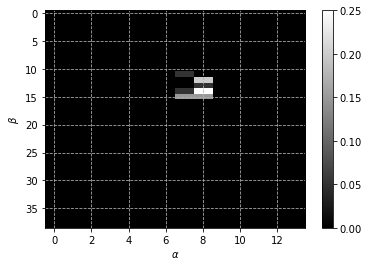

<Figure size 432x288 with 0 Axes>

In [13]:
plt.figure()
plt.imshow(success_rate[2:41, 2:16][::-1, :] / n_sample, aspect='0.3', cmap='gray')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.colorbar()
plt.grid(linestyle = '--')
plt.show()
plt.savefig("exact_recovery_SFCPQR")

In [ ]:
initial_cmap = cm.get_cmap('gray')
reversed_cmap=initial_cmap.reversed()

plt.figure()
plt.imshow(angle_error[2:41, 2:16][::-1, :] / n_sample, aspect='0.3', extent=[2, 15, 2, 40], cmap=reversed_cmap)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.colorbar()
plt.grid(linestyle = '--')
plt.show()
plt.savefig("angle_recovery_SFCPQR")